
# Static Jupiter + Protoplanetary Disk

Goal: Seed a broad, low-eccentricity protoplanetary disk and let it evolve with Jupiter fixed at ~5.2 AU (no migration) to see whether Trojans and belt structure emerge.


## 1. Setup and Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from amuse.units import units, constants, nbody_system
from amuse.datamodel import Particles
from amuse.community.huayno.interface import Huayno
from amuse.ext.orbital_elements import orbital_elements_from_binary, new_binary_from_orbital_elements
from amuse.couple import bridge
from datetime import datetime
import pickle

print('AMUSE modules loaded successfully!')

AMUSE modules loaded successfully!


/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/support/options.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 2. Solar System Parameters

In [2]:

# Star
star_mass = 1.0 | units.MSun

# Planets: Inner planets (no Mercury) + Outer planets
planet_data = {
    'Venus':   {'mass': 0.815,  'a': 0.72,  'e': 0.007,  'i': 3.39},
    'Earth':   {'mass': 1.0,    'a': 1.0,   'e': 0.017,  'i': 0.0},
    'Mars':    {'mass': 0.107,  'a': 1.52,  'e': 0.093,  'i': 1.85},
    'Jupiter': {'mass': 317.8,  'a': 4.8,   'e': 0.0489, 'i': 1.30},  # Fixed orbit (no migration)
    'Saturn':  {'mass': 95.16,  'a': 9.58,  'e': 0.056,  'i': 2.49},
    'Uranus':  {'mass': 14.54,  'a': 19.2,  'e': 0.047,  'i': 0.77},
    'Neptune': {'mass': 17.15,  'a': 30.07, 'e': 0.009,  'i': 1.77},
}

print(f'Star mass: {star_mass}')
print(f'Number of planets: {len(planet_data)}')
for name, data in planet_data.items():
    print(f"{name:8s} {data['mass']:6.2f} MEarth, a={data['a']:5.2f} AU")


Star mass: 1.0 MSun
Number of planets: 7
Venus      0.81 MEarth, a= 0.72 AU
Earth      1.00 MEarth, a= 1.00 AU
Mars       0.11 MEarth, a= 1.52 AU
Jupiter  317.80 MEarth, a= 4.80 AU
Saturn    95.16 MEarth, a= 9.58 AU
Uranus    14.54 MEarth, a=19.20 AU
Neptune   17.15 MEarth, a=30.07 AU


## 3. Create Massive Bodies (Sun + Planets)

In [3]:
def create_massive_bodies():
    """Create Sun + 7 planets (Venus, Earth, Mars, Jupiter, Saturn, Uranus, Neptune)."""
    # Sun
    sun = Particles(1)
    sun.mass = star_mass
    sun.position = [0, 0, 0] | units.AU
    sun.velocity = [0, 0, 0] | units.km/units.s
    sun.name = 'Sun'
    
    # Planets
    planets = Particles()
    np.random.seed(42)
    
    for name, data in planet_data.items():
        planet_mass = data['mass'] | units.MEarth
        a = data['a'] | units.AU
        e = data['e']
        inc = data['i'] | units.deg
        
        # Random orbital angles
        true_anom = 360.0 * np.random.random() | units.deg
        long_asc_node = 360.0 * np.random.random() | units.deg
        arg_periapsis = 360.0 * np.random.random() | units.deg
        
        binary = new_binary_from_orbital_elements(
            star_mass, planet_mass, a, e,
            true_anom, inc, long_asc_node, arg_periapsis,
            G=constants.G
        )
        
        planet = Particles(1)
        planet.mass = binary[1].mass
        planet.position = binary[1].position
        planet.velocity = binary[1].velocity
        planet.name = name
        planets.add_particle(planet)
    
    # Combine
    massive_bodies = Particles()
    massive_bodies.add_particles(sun)
    massive_bodies.add_particles(planets)
    massive_bodies.move_to_center()
    
    return massive_bodies

massive_bodies = create_massive_bodies()
print(f'Created {len(massive_bodies)} massive bodies')
for body in massive_bodies:
    r = body.position.length().value_in(units.AU)
    print(f"{body.name:8s} r={r:5.2f} AU")

Created 8 massive bodies
Sun      r= 0.00 AU
Venus    r= 0.72 AU
Earth    r= 1.01 AU
Mars     r= 1.39 AU
Jupiter  r= 4.84 AU
Saturn   r= 9.29 AU
Uranus   r=18.80 AU
Neptune  r=30.31 AU


/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/ext/orbital_elements.py:344: UserWarning: new_binary_from_orbital_elements is deprecated, use generate_binaries instead
  warnings.warn(


## 4. Create Planetesimals (Test Particles)

In [4]:

def create_planetesimals(n_particles=10000):
    """Create a protoplanetary disk (massless tracers).

    Regions:
    - Inner disk (0.7-3 AU): 50%
    - Mid disk feeding the belt (3-10 AU): 30%
    - Co-orbital seeds near Jupiter (~4.8 AU): 15%
    - Outer disk (10-30 AU): 5%
    """
    planetesimals = Particles(n_particles)
    np.random.seed(123)

    def sample_powerlaw(r_min, r_max, p=-1.5):
        """Sample a semi-major axis with surface-density ~ r^p."""
        u = np.random.random()
        if abs(p + 1) < 1e-8:
            return r_min * (r_max / r_min) ** u
        return (r_min**(p + 1) + u * (r_max**(p + 1) - r_min**(p + 1))) ** (1 / (p + 1))

    for i, p in enumerate(planetesimals):
        u = np.random.random()
        true_anom = 360.0 * np.random.random() | units.deg

        if u < 0.50:
            # Warm inner disk feeding terrestrial region
            a = sample_powerlaw(0.7, 3.0) | units.AU
        elif u < 0.80:
            # Middle disk feeding the belt
            a = sample_powerlaw(3.0, 10.0) | units.AU
        elif u < 0.95:
            # Co-orbital seeds around Jupiter; bias angles toward L4/L5
            a = (4.8 + 0.2 * np.random.randn()) | units.AU  # Gaussian centered at 4.8 AU
            angle_center = 60 if np.random.random() < 0.5 else -60
            true_anom = (angle_center + 15 * np.random.uniform(-1, 1)) | units.deg
        else:
            # Sparse outer disk / scattered population
            a = sample_powerlaw(10.0, 30.0, p=-2.0) | units.AU

        e = 0.05 * np.random.random()  # Cold disk
        inc = (3.0 * np.random.random()) | units.deg

        long_asc_node = 360.0 * np.random.random() | units.deg
        arg_periapsis = 360.0 * np.random.random() | units.deg

        binary = new_binary_from_orbital_elements(
            star_mass, 0 | units.MSun,  # Massless!
            a, e, true_anom, inc, long_asc_node, arg_periapsis,
            G=constants.G
        )

        p.mass = 0 | units.MSun
        p.position = binary[1].position
        p.velocity = binary[1].velocity
        p.name = f'asteroid_{i:04d}'

    return planetesimals

# Start with 10k tracers in the disk
planetesimals = create_planetesimals(n_particles=10000)
print(f'Created {len(planetesimals)} planetesimals')
print('  - 50% inner disk (0.7-3 AU)')
print('  - 30% mid disk (3-10 AU)')
print('  - 15% co-orbital seeds near Jupiter')
print('  - 5% outer/scattered disk (10-30 AU)')
print('Jupiter is fixed; any Trojan/belt structure now emerges from the dynamics, not migration.')


Created 10000 planetesimals
  - 50% inner disk (0.7-3 AU)
  - 30% mid disk (3-10 AU)
  - 15% co-orbital seeds near Jupiter
  - 5% outer/scattered disk (10-30 AU)
Jupiter is fixed; any Trojan/belt structure now emerges from the dynamics, not migration.


## 5. Jupiter Migration Code

This class applies migration forces to Jupiter only, following the pattern from the resonance scripts.

In [5]:
class JupiterMigrationCode:
    """Apply Type II migration to Jupiter."""
    
    def __init__(self, gravity_code, massive_bodies, jupiter_index=1):
        self.code = gravity_code
        self.massive_bodies = massive_bodies
        self.jupiter_idx = jupiter_index
        self.model_time = 0 | units.yr
        self.timestep = None
        # Migration parameters (set these after initialization!)
        self.tau_a = None
        self.tau_e = None
        
    def evolve_model(self, tend):
        """Evolve with migration kicks - Bridge will call kick()."""
        self.model_time = tend
    
    def kick(self, dt):
        """Apply migration force to Jupiter.
        
        Physics-based implementation:
        - Migration: Adds/removes angular momentum via tangential force
        - Eccentricity damping: Damps non-circular velocity component
        
        Sign convention:
        - Positive tau_a: INWARD migration (removes angular momentum)
        - Negative tau_a: OUTWARD migration (adds angular momentum)
        """
        # First sync InCode particles to local massive_bodies
        channel_from_code = self.code.particles.new_channel_to(self.massive_bodies)
        channel_from_code.copy()
        
        # Work with local particle set (can modify these!)
        jupiter = self.massive_bodies[self.jupiter_idx]
        sun = self.massive_bodies[0]
        
        # Track energy change
        de = 0 | units.J
        
        # Relative position and velocity (Jupiter relative to Sun)
        r_vec = jupiter.position - sun.position
        v_vec = jupiter.velocity - sun.velocity
        
        r = r_vec.length()
        r_hat = r_vec / r
        
        # Radial and tangential velocity components
        v_r = (v_vec * r_hat).sum()  # Radial velocity (dot product)
        v_r_vec = v_r * r_hat
        v_tan_vec = v_vec - v_r_vec  # Tangential velocity vector
        v_tan = v_tan_vec.length()
        
        # Migration force (changes semi-major axis)
        if self.tau_a is not None:
            # Type II migration via tangential force
            # Positive tau_a = INWARD (remove angular momentum)
            # Negative tau_a = OUTWARD (add angular momentum)
            # 
            # Theory: da/dt = -2a/tau_a for inward migration
            # For circular orbits: v = sqrt(GM/a), so v ∝ 1/sqrt(a)
            # Therefore: dv/dt = -v/(2*tau_a)  <-- Factor of 2!
            
            if v_tan > (0 | units.km/units.s):  # Avoid division by zero
                a_migration = -(v_tan_vec / (2.0 * self.tau_a))
                
                jupiter.vx += a_migration[0] * dt
                jupiter.vy += a_migration[1] * dt
                jupiter.vz += a_migration[2] * dt
        
        # Eccentricity damping (circularizes orbit)
        if self.tau_e is not None:
            # Circular velocity at current radius
            v_circ = (constants.G * sun.mass / r).sqrt()
            
            # Circular velocity vector (perpendicular to radius)
            # Direction: tangential, magnitude: v_circ
            if v_tan > (0 | units.km/units.s):
                v_circ_vec = (v_circ / v_tan) * v_tan_vec
            else:
                v_circ_vec = v_tan_vec  # Fallback if v_tan ~ 0
            
            # Eccentricity velocity (deviation from circular)
            v_ecc = v_vec - v_circ_vec
            
            # Damp eccentricity: dv/dt = -v_ecc / tau_e
            a_damping = -v_ecc / self.tau_e
            
            jupiter.vx += a_damping[0] * dt
            jupiter.vy += a_damping[1] * dt
            jupiter.vz += a_damping[2] * dt
        
        # Sync modified velocities back to InCode particles
        channel_to_code = self.massive_bodies.new_channel_to(self.code.particles)
        channel_to_code.copy()
        
        return de

print('JupiterMigrationCode defined!')

JupiterMigrationCode defined!


## 6. External Gravity Field for Planetesimals

Planetesimals feel gravity from massive bodies but don't interact with each other.

In [6]:
class ExternalGravityField:
    """Gravity field from massive bodies for test particles."""
    
    def __init__(self, massive_bodies):
        self.massive_bodies = massive_bodies
        self.model_time = 0 | units.yr
    
    def get_gravity_at_point(self, eps, x, y, z):
        """Compute gravitational acceleration at position (x,y,z)."""
        ax = 0 | units.AU / units.yr**2
        ay = 0 | units.AU / units.yr**2
        az = 0 | units.AU / units.yr**2
        
        for body in self.massive_bodies:
            dx = x - body.x
            dy = y - body.y
            dz = z - body.z
            r2 = dx**2 + dy**2 + dz**2
            r = r2.sqrt()
            
            # Newton's law
            force_factor = -constants.G * body.mass / (r2 * r)
            ax += force_factor * dx
            ay += force_factor * dy
            az += force_factor * dz
        
        return ax, ay, az
    
    def evolve_model(self, tend):
        """Dummy evolve - Bridge handles it."""
        self.model_time = tend

print('ExternalGravityField defined!')

ExternalGravityField defined!


## 7. Planetesimal Integrator (Leapfrog)

Simple symplectic integrator for test particles in external field.

In [7]:
class PlanetesimalIntegrator:
    """VECTORIZED Leapfrog integrator for planetesimals in external field.
    
    Optimized to avoid per-step Particles writes:
    - Keep positions/velocities in NumPy arrays between steps
    - Only sync back to AMUSE Particles when requested (e.g., at snapshots)
    """
    
    def __init__(self, particles, gravity_field):
        self.particles = particles
        self.gravity_field = gravity_field
        self.model_time = 0 | units.yr
        
        # Cache particle state in arrays (AU, AU/yr)
        self._x = np.array([p.x.value_in(units.AU) for p in particles])
        self._y = np.array([p.y.value_in(units.AU) for p in particles])
        self._z = np.array([p.z.value_in(units.AU) for p in particles])
        self._vx = np.array([p.vx.value_in(units.AU/units.yr) for p in particles])
        self._vy = np.array([p.vy.value_in(units.AU/units.yr) for p in particles])
        self._vz = np.array([p.vz.value_in(units.AU/units.yr) for p in particles])
    
    def _massive_arrays(self):
        bodies = self.gravity_field.massive_bodies
        mx = np.array([b.x.value_in(units.AU) for b in bodies])
        my = np.array([b.y.value_in(units.AU) for b in bodies])
        mz = np.array([b.z.value_in(units.AU) for b in bodies])
        masses = np.array([b.mass.value_in(units.MSun) for b in bodies])
        return mx, my, mz, masses
    
    def evolve_model(self, tend):
        """Vectorized Leapfrog kick-drift-kick (array-only between syncs)."""
        dt = tend - self.model_time
        dt_val = dt.value_in(units.yr)
        n = len(self._x)
        mx, my, mz, masses = self._massive_arrays()
        G_val = constants.G.value_in(units.AU**3 / (units.MSun * units.yr**2))
        
        def compute_accel(x, y, z):
            dx = x[:, None] - mx[None, :]
            dy = y[:, None] - my[None, :]
            dz = z[:, None] - mz[None, :]
            r2 = dx*dx + dy*dy + dz*dz
            r3 = r2 * np.sqrt(r2)
            factor = (-G_val * masses) / r3
            ax = np.sum(factor * dx, axis=1)
            ay = np.sum(factor * dy, axis=1)
            az = np.sum(factor * dz, axis=1)
            return ax, ay, az
        
        # Half kick
        ax, ay, az = compute_accel(self._x, self._y, self._z)
        self._vx += 0.5 * ax * dt_val
        self._vy += 0.5 * ay * dt_val
        self._vz += 0.5 * az * dt_val
        
        # Full drift
        self._x += self._vx * dt_val
        self._y += self._vy * dt_val
        self._z += self._vz * dt_val
        
        # Half kick
        ax, ay, az = compute_accel(self._x, self._y, self._z)
        self._vx += 0.5 * ax * dt_val
        self._vy += 0.5 * ay * dt_val
        self._vz += 0.5 * az * dt_val
        
        self.model_time = tend
    
    def sync_to_particles(self):
        """Write cached arrays back to AMUSE Particles (use at snapshots)."""
        for i, p in enumerate(self.particles):
            p.x = self._x[i] | units.AU
            p.y = self._y[i] | units.AU
            p.z = self._z[i] | units.AU
            p.vx = self._vx[i] | units.AU/units.yr
            p.vy = self._vy[i] | units.AU/units.yr
            p.vz = self._vz[i] | units.AU/units.yr

print('PlanetesimalIntegrator defined (array-cached, vectorized)!')

PlanetesimalIntegrator defined (array-cached, vectorized)!


## 8. Setup Two-Bridge System

In [8]:

# Bridge 1: Massive bodies with Jupiter held fixed (migration disabled)
converter = nbody_system.nbody_to_si(massive_bodies.total_mass(), 10 | units.AU)
gravity_massive = Huayno(converter, number_of_workers=1, channel_type='sockets')
gravity_massive.parameters.inttype_parameter = 13  # Symplectic integrator
gravity_massive.parameters.timestep_parameter = 0.05  # Fine timestep for accuracy
gravity_massive.particles.add_particles(massive_bodies)

# Keep the migration code wrapper for compatibility, but turn migration off
migration_code = JupiterMigrationCode(gravity_massive, massive_bodies, jupiter_index=4)
migration_code.timestep = 0.1 | units.yr  # Kick cadence (no-op with tau=None)
migration_code.tau_a = None  # Disable semi-major-axis migration
migration_code.tau_e = None  # Disable eccentricity damping

# Bridge for massive bodies (no migration kicks applied)
bridge_massive = bridge.Bridge(use_threading=False)
bridge_massive.add_system(gravity_massive)
bridge_massive.add_code(migration_code)
bridge_massive.timestep = 0.1 | units.yr

print('Bridge 1 (massive bodies, no Jupiter migration) created!')
print('Jupiter migration disabled: tau_a=None, tau_e=None')

# Bridge 2: Planetesimals as tracers
gravity_field = ExternalGravityField(massive_bodies)
planetesimal_code = PlanetesimalIntegrator(planetesimals, gravity_field)

bridge_planetesimals = bridge.Bridge(use_threading=False)
bridge_planetesimals.add_system(planetesimal_code)
bridge_planetesimals.add_system(gravity_field)
bridge_planetesimals.timestep = 0.1 | units.yr  # Match Bridge 1 for synchronization

print('Bridge 2 (planetesimals) created!')
print(f'Planetesimal timestep: {bridge_planetesimals.timestep}')
print('Two-bridge system ready: Jupiter held fixed, planetesimals as tracers.')


Bridge 1 (massive bodies, no Jupiter migration) created!
Jupiter migration disabled: tau_a=None, tau_e=None
Bridge 2 (planetesimals) created!
Planetesimal timestep: 0.1 yr
Two-bridge system ready: Jupiter held fixed, planetesimals as tracers.



## 8.5 Migration Calibration (disabled)

Migration is turned off for this disk experiment, so skip the calibration cells.


In [9]:

print('Migration calibration skipped: Jupiter is fixed for this run.')


Migration calibration skipped: Jupiter is fixed for this run.



## 8.7 Re-initialize System (not needed)

The system above already represents the static-Jupiter disk. Continue to the simulation section.


In [10]:

print('System already initialized for non-migrating Jupiter; no re-initialization performed.')


System already initialized for non-migrating Jupiter; no re-initialization performed.


In [11]:

print('Skipping tau_a calculation: Jupiter is not migrating in this experiment.')


Skipping tau_a calculation: Jupiter is not migrating in this experiment.


## 9. Run Simulation

## 8.5 Optimization Tips

**Speed vs Accuracy Tradeoffs:**

1. **Reduce snapshots**: `n_snapshots = 50` instead of 200 (4x faster)
2. **Increase timestep**: `dt = 2 | units.yr` instead of 1 yr (2x faster) 
3. **Faster migration**: `tau_a = -1000 | units.yr` instead of -10000 (see migration 10x faster)
4. **Fewer particles**: Test with 1000 particles first, then scale to 10,000
5. **Shorter runs**: Test with 1000 yr, then run full 10,000 yr simulation

**Expected Performance (with vectorization):**
- 1,000 particles, 1000 yr: ~30 seconds
- 10,000 particles, 1000 yr: ~3-5 minutes  
- 10,000 particles, 10,000 yr: ~30-50 minutes

In [12]:
# Function to count Trojans in L4 and L5
def compute_trojan_counts(massive_bodies, planetesimals):
    """Count planetesimals in Jupiter's L4 and L5 Trojan regions.
    
    Returns:
    --------
    n4, n5 : int
        Number of particles in L4 and L5 regions
    """
    jupiter = massive_bodies[4]  # Jupiter at index 4
    lambda_j = np.arctan2(jupiter.y.value_in(units.AU), jupiter.x.value_in(units.AU))
    a_j = jupiter.position.length()
    
    dlam = []
    is_coorb = []
    for p in planetesimals:
        lam = np.arctan2(p.y.value_in(units.AU), p.x.value_in(units.AU))
        d = np.arctan2(np.sin(lam - lambda_j), np.cos(lam - lambda_j))
        dlam.append(d)
        # Co-orbital: within 7% of Jupiter's semi-major axis
        is_coorb.append(abs(p.position.length()/a_j - 1) < 0.07)
    
    dlam = np.array(dlam)
    is_coorb = np.array(is_coorb)
    
    # L4: +60° from Jupiter (±25° sector)
    L4 = (dlam > np.deg2rad(60-25)) & (dlam < np.deg2rad(60+25)) & is_coorb
    # L5: -60° from Jupiter (±25° sector)
    L5 = (dlam < np.deg2rad(-60+25)) & (dlam > np.deg2rad(-60-25)) & is_coorb
    
    return L4.sum(), L5.sum()

print('Trojan counting function defined!')


Trojan counting function defined!


In [13]:
# Simulation parameters
end_time = 5000 | units.yr  # 1 kyr run for testing
dt = 0.1 | units.yr
n_snapshots = 200
snapshot_interval = end_time / n_snapshots

# Storage
times = []
snapshots_massive = []
snapshots_planetesimals = []
l4_counts = []  # NEW: Track L4 population
l5_counts = []  # NEW: Track L5 population

print('='*60)
print('Running Simulation')
print('='*60)
print(f'Duration: {end_time}')
print(f'Snapshots: {n_snapshots}')
print(f'Massive bodies: {len(massive_bodies)}')
print(f'Planetesimals: {len(planetesimals)}')
print('='*60)

time = 0 | units.yr
next_snapshot = 0 | units.yr
snapshot_count = 0

start_time = datetime.now()

# Save initial snapshot (t=0)
times.append(time.value_in(units.yr))
snapshots_massive.append(massive_bodies.copy())
snapshots_planetesimals.append(planetesimals.copy())
n4, n5 = compute_trojan_counts(massive_bodies, planetesimals)  # NEW: Compute Trojan counts
l4_counts.append(n4)  # NEW
l5_counts.append(n5)  # NEW
jupiter = massive_bodies[4]
r_jup = jupiter.position.length().value_in(units.AU)
print(f'Snapshot {snapshot_count}/{n_snapshots}: t={time.value_in(units.yr):.1f} yr, Jupiter r={r_jup:.3f} AU, L4={n4}, L5={n5}')  # NEW: Print counts
snapshot_count += 1
next_snapshot += snapshot_interval

while time < end_time:
    # Evolve massive bodies (with migration)
    bridge_massive.evolve_model(time + dt)
    
    # Copy updated positions to massive_bodies
    channel_from_massive = gravity_massive.particles.new_channel_to(massive_bodies)
    channel_from_massive.copy()
    
    # Update gravity field for planetesimals
    gravity_field.massive_bodies = massive_bodies
    
    # Evolve planetesimals (array-cached; no per-step Particles write)
    bridge_planetesimals.evolve_model(time + dt)
    
    time += dt
    
    # Save snapshot AFTER evolution
    if time >= next_snapshot:
        planetesimal_code.sync_to_particles()
        times.append(time.value_in(units.yr))
        snapshots_massive.append(massive_bodies.copy())
        snapshots_planetesimals.append(planetesimals.copy())
        n4, n5 = compute_trojan_counts(massive_bodies, planetesimals)  # NEW: Compute Trojan counts
        l4_counts.append(n4)  # NEW
        l5_counts.append(n5)  # NEW
        
        # Progress
        jupiter = massive_bodies[4]
        r_jup = jupiter.position.length().value_in(units.AU)
        print(f'Snapshot {snapshot_count}/{n_snapshots}: t={time.value_in(units.yr):.1f} yr, Jupiter r={r_jup:.3f} AU, L4={n4}, L5={n5}')  # NEW: Print counts
        
        snapshot_count += 1
        next_snapshot += snapshot_interval

# Ensure final particle set matches cached arrays
planetesimal_code.sync_to_particles()

elapsed = (datetime.now() - start_time).total_seconds()
print('='*60)
print(f'Simulation Complete!')
print(f'Time: {elapsed:.1f} seconds')
print(f'Snapshots: {len(times)}')
print(f'Final L4 count: {l4_counts[-1]}')  # NEW: Summary
print(f'Final L5 count: {l5_counts[-1]}')  # NEW: Summary
print('='*60)


Running Simulation
Duration: 5000 yr
Snapshots: 200
Massive bodies: 8
Planetesimals: 10000
Snapshot 0/200: t=0.0 yr, Jupiter r=4.845 AU, L4=181, L5=203
Snapshot 1/200: t=25.0 yr, Jupiter r=4.594 AU, L4=164, L5=68
Snapshot 2/200: t=50.0 yr, Jupiter r=5.011 AU, L4=233, L5=65
Snapshot 3/200: t=75.0 yr, Jupiter r=4.601 AU, L4=159, L5=153
Snapshot 4/200: t=100.1 yr, Jupiter r=4.850 AU, L4=171, L5=177
Snapshot 5/200: t=125.1 yr, Jupiter r=4.885 AU, L4=111, L5=191
Snapshot 6/200: t=150.1 yr, Jupiter r=4.569 AU, L4=100, L5=115
Snapshot 7/200: t=175.1 yr, Jupiter r=5.011 AU, L4=127, L5=121
Snapshot 8/200: t=200.1 yr, Jupiter r=4.641 AU, L4=151, L5=158
Snapshot 9/200: t=225.1 yr, Jupiter r=4.789 AU, L4=138, L5=163
Snapshot 10/200: t=250.1 yr, Jupiter r=4.931 AU, L4=90, L5=136
Snapshot 11/200: t=275.1 yr, Jupiter r=4.550 AU, L4=86, L5=125
Snapshot 12/200: t=300.1 yr, Jupiter r=4.986 AU, L4=151, L5=142
Snapshot 13/200: t=325.0 yr, Jupiter r=4.709 AU, L4=143, L5=131
Snapshot 14/200: t=350.0 yr, Jup

In [14]:
# Function to count Trojans in L4 and L5
def compute_trojan_counts(massive_bodies, planetesimals):
    """Count planetesimals in Jupiter's L4 and L5 Trojan regions.
    
    Returns:
    --------
    n4, n5 : int
        Number of particles in L4 and L5 regions
    """
    jupiter = massive_bodies[4]  # Jupiter at index 4
    lambda_j = np.arctan2(jupiter.y.value_in(units.AU), jupiter.x.value_in(units.AU))
    a_j = jupiter.position.length()
    
    dlam = []
    is_coorb = []
    for p in planetesimals:
        lam = np.arctan2(p.y.value_in(units.AU), p.x.value_in(units.AU))
        d = np.arctan2(np.sin(lam - lambda_j), np.cos(lam - lambda_j))
        dlam.append(d)
        # Co-orbital: within 7% of Jupiter's semi-major axis
        is_coorb.append(abs(p.position.length()/a_j - 1) < 0.07)
    
    dlam = np.array(dlam)
    is_coorb = np.array(is_coorb)
    
    # L4: +60° from Jupiter (±25° sector)
    L4 = (dlam > np.deg2rad(60-25)) & (dlam < np.deg2rad(60+25)) & is_coorb
    # L5: -60° from Jupiter (±25° sector)
    L5 = (dlam < np.deg2rad(-60+25)) & (dlam > np.deg2rad(-60-25)) & is_coorb
    
    return L4.sum(), L5.sum()

print('Trojan counting function defined!')


Trojan counting function defined!


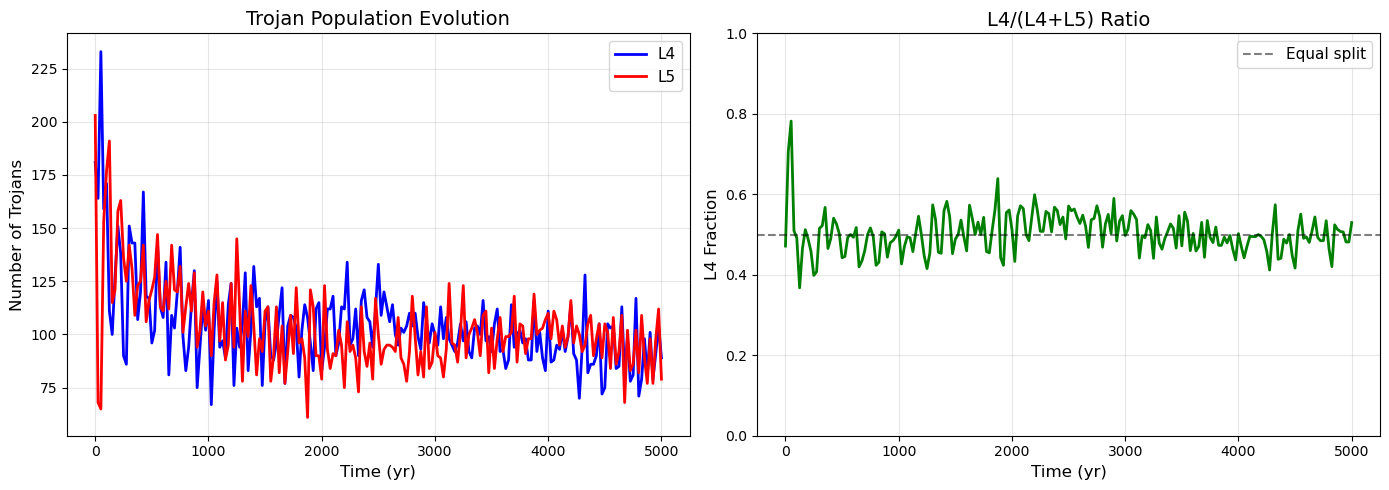

Trojan Population Summary
Initial L4: 181, L5: 203, Total: 384
Final L4: 89, L5: 79, Total: 168
L4/L5 initial ratio: 0.892
L4/L5 final ratio: 1.127
Retention: 43.7%


In [15]:
# Visualize L4 and L5 Trojan populations over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: L4 and L5 counts
ax1.plot(times, l4_counts, 'b-', label='L4', linewidth=2)
ax1.plot(times, l5_counts, 'r-', label='L5', linewidth=2)
ax1.set_xlabel('Time (yr)', fontsize=12)
ax1.set_ylabel('Number of Trojans', fontsize=12)
ax1.set_title('Trojan Population Evolution', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Right panel: L4 fraction
l4_fraction = np.array(l4_counts) / (np.array(l4_counts) + np.array(l5_counts) + 1e-10)
ax2.plot(times, l4_fraction, 'g-', linewidth=2)
ax2.axhline(0.5, color='k', linestyle='--', alpha=0.5, label='Equal split')
ax2.set_xlabel('Time (yr)', fontsize=12)
ax2.set_ylabel('L4 Fraction', fontsize=12)
ax2.set_title('L4/(L4+L5) Ratio', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary statistics
print('='*60)
print('Trojan Population Summary')
print('='*60)
print(f'Initial L4: {l4_counts[0]}, L5: {l5_counts[0]}, Total: {l4_counts[0]+l5_counts[0]}')
print(f'Final L4: {l4_counts[-1]}, L5: {l5_counts[-1]}, Total: {l4_counts[-1]+l5_counts[-1]}')
print(f'L4/L5 initial ratio: {l4_counts[0]/(l5_counts[0]+1e-10):.3f}')
print(f'L4/L5 final ratio: {l4_counts[-1]/(l5_counts[-1]+1e-10):.3f}')
print(f'Retention: {100*(l4_counts[-1]+l5_counts[-1])/(l4_counts[0]+l5_counts[0]+1e-10):.1f}%')
print('='*60)


In [16]:
import numpy as np
from amuse.units import units, constants

a_list = []
e_list = []
for snap in snapshots_massive:
    sun = snap[0]
    jup = snap[4]
    r_vec = jup.position - sun.position
    v_vec = jup.velocity - sun.velocity
    r = r_vec.length()
    v = v_vec.length()
    mu = constants.G * (sun.mass + jup.mass)

    # Specific orbital energy and angular momentum
    E = 0.5 * v * v - mu / r
    h_vec = r_vec.cross(v_vec)
    h = h_vec.length()

    # Semi-major axis from energy
    a = -mu / (2 * E)

    # Eccentricity from energy and angular momentum (dimensionless)
    e_sq = 1 + (2 * E * h * h) / (mu * mu)
    if hasattr(e_sq, "value_in"):
        e_sq_val = e_sq.value_in(1)
    elif hasattr(e_sq, "number"):
        e_sq_val = e_sq.number
    else:
        e_sq_val = float(e_sq)
    e_val = np.sqrt(max(e_sq_val, 0.0))

    a_list.append(a.value_in(units.AU))
    e_list.append(e_val)

print(f"a min/max: {min(a_list):.3f}/{max(a_list):.3f} AU, final a={a_list[-1]:.3f} AU")
print(f"e min/max: {min(e_list):.4f}/{max(e_list):.4f}, final e={e_list[-1]:.4f}")


a min/max: 4.781/4.783 AU, final a=4.782 AU
e min/max: 0.0484/0.0512, final e=0.0499


## 10. Visualize Results

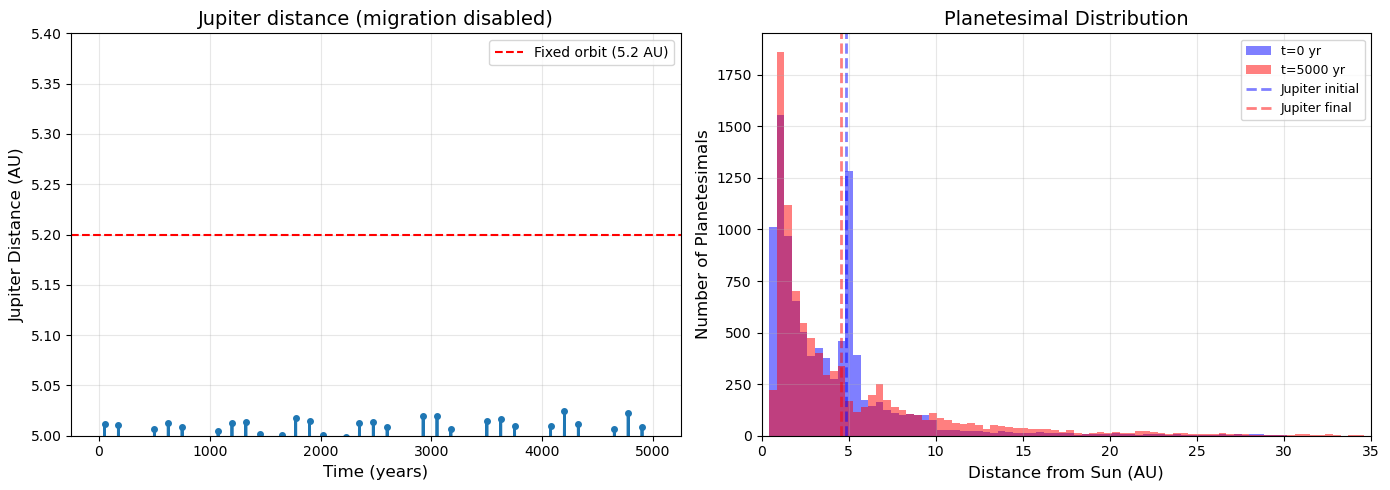

Jupiter stayed between 4.5326 and 5.0245 AU (delta=0.49193 AU)


In [17]:

# Track Jupiter's distance (should remain ~constant) and planetesimal distribution
jupiter_distances = []
for snap in snapshots_massive:
    jupiter = snap[4]  # Jupiter is at index 4
    r = jupiter.position.length().value_in(units.AU)
    jupiter_distances.append(r)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Jupiter distance
ax1.plot(times, jupiter_distances, 'o-', linewidth=2, markersize=4)
ax1.axhline(5.2, color='red', linestyle='--', label='Fixed orbit (5.2 AU)')
ax1.set_xlabel('Time (years)', fontsize=12)
ax1.set_ylabel('Jupiter Distance (AU)', fontsize=12)
ax1.set_title('Jupiter distance (migration disabled)', fontsize=14)
ax1.set_ylim([5.0, 5.4])
ax1.grid(True, alpha=0.3)
ax1.legend()

# Planetesimal distribution (initial vs final)
initial = snapshots_planetesimals[0]
final = snapshots_planetesimals[-1]

r_init = [p.position.length().value_in(units.AU) for p in initial]
r_final = [p.position.length().value_in(units.AU) for p in final]

ax2.hist(r_init, bins=80, range=(0, 35), alpha=0.5, label=f't={times[0]:.0f} yr', color='blue')
ax2.hist(r_final, bins=80, range=(0, 35), alpha=0.5, label=f't={times[-1]:.0f} yr', color='red')
ax2.axvline(jupiter_distances[0], color='blue', linestyle='--', alpha=0.5, linewidth=2, label='Jupiter initial')
ax2.axvline(jupiter_distances[-1], color='red', linestyle='--', alpha=0.5, linewidth=2, label='Jupiter final')
ax2.set_xlabel('Distance from Sun (AU)', fontsize=12)
ax2.set_ylabel('Number of Planetesimals', fontsize=12)
ax2.set_title('Planetesimal Distribution', fontsize=14)
ax2.set_xlim([0, 35])
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

j_min, j_max = min(jupiter_distances), max(jupiter_distances)
print(f'Jupiter stayed between {j_min:.4f} and {j_max:.4f} AU (delta={j_max - j_min:.5f} AU)')


## 10.1 Check Jupiter's Orbital Motion

Jupiter should be orbiting the Sun! Let's verify it's actually rotating.

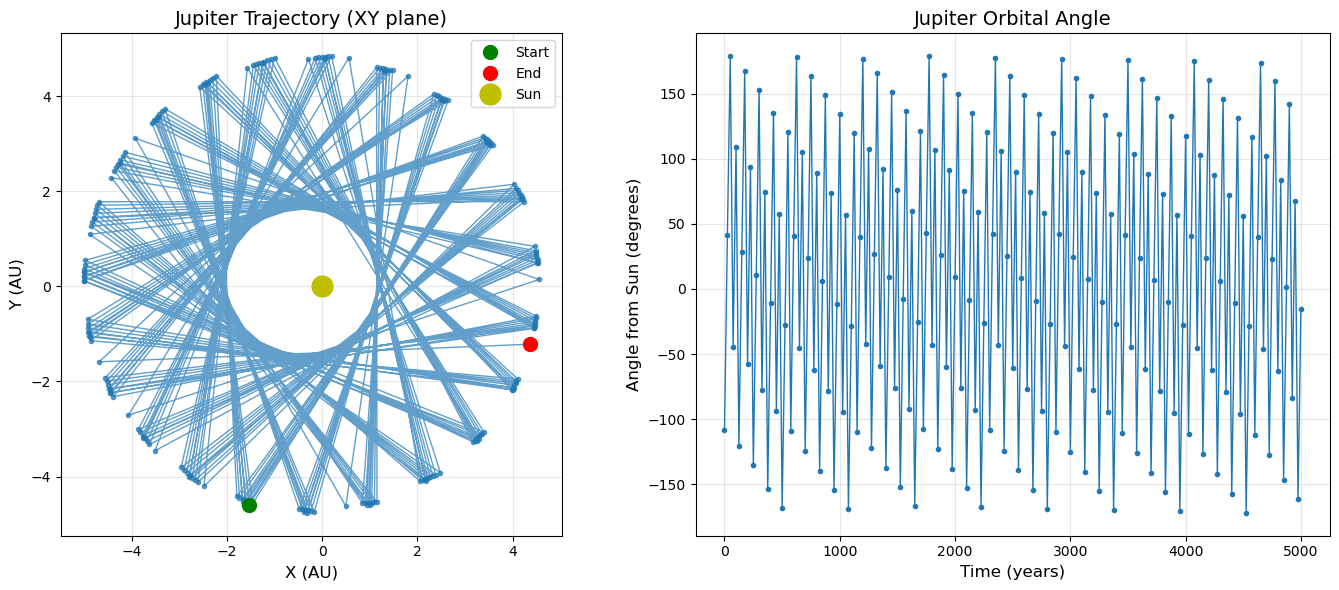

Jupiter orbital motion over 5000.0 years:
  Total rotation: 28173.0°
  Orbits completed: 78.26
  Expected full orbit at 4.8 AU: ~11.6 years
  Expected orbits: 431.03

✓ Jupiter IS orbiting (78.3 orbits completed)


In [18]:
# Check Jupiter's X,Y position over time
jupiter_x = []
jupiter_y = []
jupiter_angles = []

for snap in snapshots_massive:
    jupiter = snap[4]
    x = jupiter.x.value_in(units.AU)
    y = jupiter.y.value_in(units.AU)
    jupiter_x.append(x)
    jupiter_y.append(y)
    
    # Calculate angle from Sun (in degrees)
    angle = np.degrees(np.arctan2(y, x))
    jupiter_angles.append(angle)

# Plot Jupiter's XY trajectory
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: XY trajectory
ax1.plot(jupiter_x, jupiter_y, 'o-', markersize=3, linewidth=1, alpha=0.7)
ax1.plot(jupiter_x[0], jupiter_y[0], 'go', markersize=10, label='Start')
ax1.plot(jupiter_x[-1], jupiter_y[-1], 'ro', markersize=10, label='End')
ax1.plot(0, 0, 'yo', markersize=15, label='Sun')
ax1.set_xlabel('X (AU)', fontsize=12)
ax1.set_ylabel('Y (AU)', fontsize=12)
ax1.set_title('Jupiter Trajectory (XY plane)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_aspect('equal')

# Right: Angle vs time
ax2.plot(times, jupiter_angles, 'o-', markersize=3, linewidth=1)
ax2.set_xlabel('Time (years)', fontsize=12)
ax2.set_ylabel('Angle from Sun (degrees)', fontsize=12)
ax2.set_title('Jupiter Orbital Angle', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate total orbital motion (accounting for wraparounds)
total_rotation = 0.0
for i in range(1, len(jupiter_angles)):
    delta = jupiter_angles[i] - jupiter_angles[i-1]
    # Unwrap angle changes
    if delta > 180:
        delta -= 360
    elif delta < -180:
        delta += 360
    total_rotation += delta

orbits_completed = total_rotation / 360.0

print(f'Jupiter orbital motion over {times[-1]:.1f} years:')
print(f'  Total rotation: {total_rotation:.1f}°')
print(f'  Orbits completed: {orbits_completed:.2f}')
print(f'  Expected full orbit at 4.8 AU: ~11.6 years')
print(f'  Expected orbits: {(times[-1] / 11.6):.2f}')

if abs(orbits_completed) < 1:
    print(f'\n⚠️  WARNING: Jupiter barely moved in its orbit!')
    print(f'  Over 1000 years, Jupiter should complete ~86 orbits')
    print(f'  This suggests the orbital motion is NOT being integrated correctly!')
else:
    print(f'\n✓ Jupiter IS orbiting ({abs(orbits_completed):.1f} orbits completed)')
    if abs(orbits_completed) < 50:
        print(f'   But much slower than expected (~86 orbits)')
        print(f'   Actual rate: {abs(orbits_completed) / (times[-1] / 11.6) * 100:.1f}% of expected')

## 10.3 Track Planetesimal Distribution Evolution

Analyze how planetesimals are being lost/scattered over time.

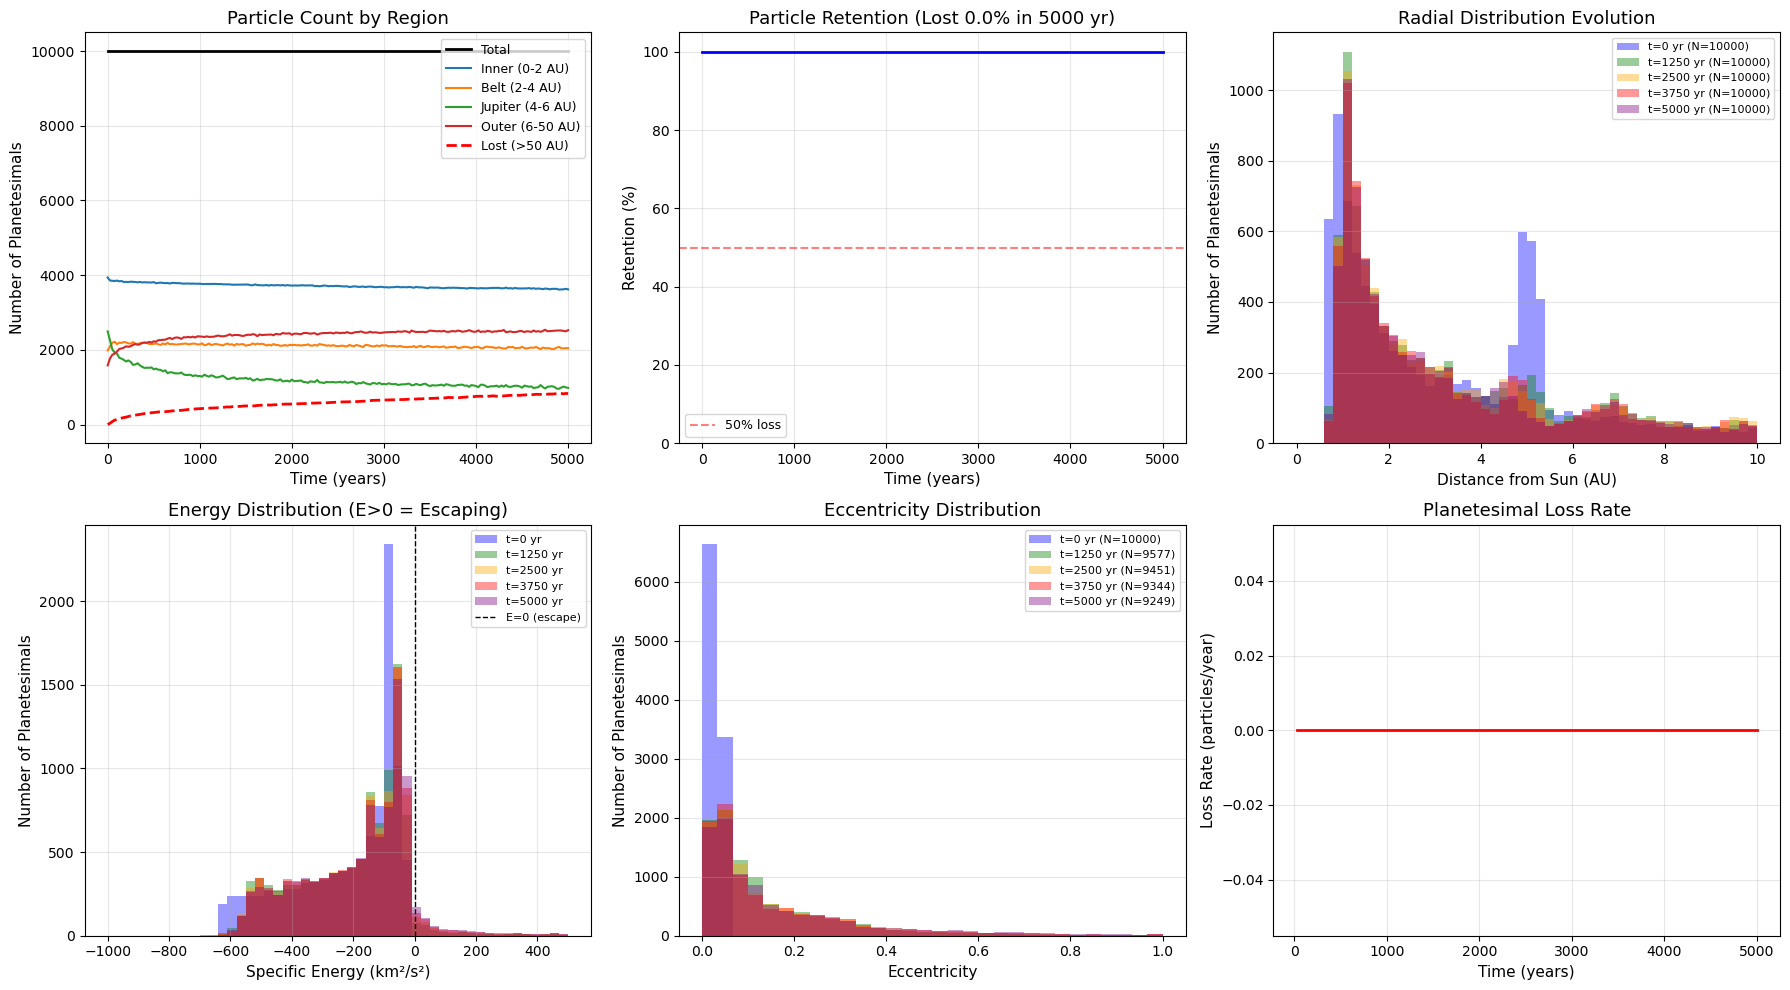

PLANETESIMAL EVOLUTION SUMMARY
Initial count:  10,000 particles
Final count:    10,000 particles
Lost:           0 particles (0.0%)
Time span:      5000 years
Average loss:   0.00 particles/year

Final distribution:
  Inner (0-2 AU):     3,618 (36.2%)
  Belt (2-4 AU):      2,044 (20.4%)
  Jupiter (4-6 AU):   983 (9.8%)
  Outer (6-50 AU):    2,525 (25.2%)
  Lost (>50 AU):      830 (8.3%)


In [19]:
# Analyze planetesimal evolution over time
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Track particles in different regions
r_cutoff = 50 | units.AU  # Beyond this = "lost"

n_total = []
n_inner = []  # 0-2 AU
n_belt = []   # 2-4 AU
n_jupiter = [] # 4-6 AU
n_outer = []  # 6-50 AU
n_lost = []   # > 50 AU

for i, snap in enumerate(snapshots_planetesimals):
    radii = [p.position.length() for p in snap]
    
    total = len(snap)
    inner = sum(1 for r in radii if r < (2 | units.AU))
    belt = sum(1 for r in radii if (2 | units.AU) <= r < (4 | units.AU))
    jup = sum(1 for r in radii if (4 | units.AU) <= r < (6 | units.AU))
    outer = sum(1 for r in radii if (6 | units.AU) <= r < r_cutoff)
    lost = sum(1 for r in radii if r >= r_cutoff)
    
    n_total.append(total)
    n_inner.append(inner)
    n_belt.append(belt)
    n_jupiter.append(jup)
    n_outer.append(outer)
    n_lost.append(lost)

# Plot 1: Particle count evolution
ax = axes[0, 0]
ax.plot(times, n_total, 'k-', linewidth=2, label='Total')
ax.plot(times, n_inner, label='Inner (0-2 AU)')
ax.plot(times, n_belt, label='Belt (2-4 AU)')
ax.plot(times, n_jupiter, label='Jupiter (4-6 AU)')
ax.plot(times, n_outer, label='Outer (6-50 AU)')
ax.plot(times, n_lost, 'r--', linewidth=2, label='Lost (>50 AU)')
ax.set_xlabel('Time (years)', fontsize=11)
ax.set_ylabel('Number of Planetesimals', fontsize=11)
ax.set_title('Particle Count by Region', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 2: Retention fraction
ax = axes[0, 1]
retention = np.array(n_total) / n_total[0] * 100
ax.plot(times, retention, 'b-', linewidth=2)
ax.axhline(50, color='red', linestyle='--', alpha=0.5, label='50% loss')
ax.set_xlabel('Time (years)', fontsize=11)
ax.set_ylabel('Retention (%)', fontsize=11)
ax.set_title(f'Particle Retention (Lost {100-retention[-1]:.1f}% in {times[-1]:.0f} yr)', fontsize=13)
ax.set_ylim([0, 105])
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# Plot 3: Radial histograms at different times
ax = axes[0, 2]
snapshot_indices = [0, len(snapshots_planetesimals)//4, len(snapshots_planetesimals)//2, 
                   3*len(snapshots_planetesimals)//4, -1]
colors = ['blue', 'green', 'orange', 'red', 'purple']
for idx, color in zip(snapshot_indices, colors):
    snap = snapshots_planetesimals[idx]
    radii = [p.position.length().value_in(units.AU) for p in snap]
    t = times[idx]
    ax.hist(radii, bins=50, range=(0, 10), alpha=0.4, color=color, 
           label=f't={t:.0f} yr (N={len(radii)})')
ax.set_xlabel('Distance from Sun (AU)', fontsize=11)
ax.set_ylabel('Number of Planetesimals', fontsize=11)
ax.set_title('Radial Distribution Evolution', fontsize=13)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Energy histogram (check for ejections)
ax = axes[1, 0]
for idx, color in zip(snapshot_indices, colors):
    snap_massive = snapshots_massive[idx]
    snap_planetes = snapshots_planetesimals[idx]
    sun = snap_massive[0]
    
    energies = []
    for p in snap_planetes:
        r = (p.position - sun.position).length()
        v = (p.velocity - sun.velocity).length()
        # Specific orbital energy
        E = 0.5 * v**2 - constants.G * sun.mass / r
        energies.append(E.value_in(units.km**2 / units.s**2))
    
    t = times[idx]
    ax.hist(energies, bins=50, range=(-1000, 500), alpha=0.4, color=color,
           label=f't={t:.0f} yr')

ax.axvline(0, color='black', linestyle='--', linewidth=1, label='E=0 (escape)')
ax.set_xlabel('Specific Energy (km²/s²)', fontsize=11)
ax.set_ylabel('Number of Planetesimals', fontsize=11)
ax.set_title('Energy Distribution (E>0 = Escaping)', fontsize=13)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# Plot 5: Eccentricity evolution
ax = axes[1, 1]
for idx, color in zip(snapshot_indices, colors):
    snap_massive = snapshots_massive[idx]
    snap_planetes = snapshots_planetesimals[idx]
    sun = snap_massive[0]
    
    eccentricities = []
    for p in snap_planetes:
        r_vec = p.position - sun.position
        v_vec = p.velocity - sun.velocity
        r = r_vec.length()
        v = v_vec.length()
        
        # Specific orbital energy and angular momentum
        E = 0.5 * v**2 - constants.G * sun.mass / r
        h_vec = r_vec.cross(v_vec)
        h = h_vec.length()
        
        # Semi-major axis
        if E < (0 | units.km**2/units.s**2):
            a = -constants.G * sun.mass / (2 * E)
            # Eccentricity from vis-viva equation: e^2 = 1 + 2*E*h^2/(GM)^2
            E_val = E.value_in(units.km**2/units.s**2)
            h_val = h.value_in(units.AU**2/units.yr)
            GM_val = (constants.G * sun.mass).value_in(units.AU**3/units.yr**2)
            # Convert E to same units as GM: AU^2/yr^2
            E_converted = E_val * (units.km**2/units.s**2).value_in(units.AU**2/units.yr**2)
            e_squared_val = 1 + 2 * E_converted * h_val**2 / GM_val**2
            if e_squared_val >= 0:  # Ensure valid sqrt
                e_val = np.sqrt(e_squared_val)
                if e_val < 1.5:  # Skip hyperbolic
                    eccentricities.append(e_val)
    
    t = times[idx]
    if len(eccentricities) > 0:
        ax.hist(eccentricities, bins=30, range=(0, 1), alpha=0.4, color=color,
               label=f't={t:.0f} yr (N={len(eccentricities)})')

ax.set_xlabel('Eccentricity', fontsize=11)
ax.set_ylabel('Number of Planetesimals', fontsize=11)
ax.set_title('Eccentricity Distribution', fontsize=13)
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# Plot 6: Loss rate analysis
ax = axes[1, 2]
loss_rate = []
for i in range(1, len(times)):
    dt = times[i] - times[i-1]
    dn = n_total[i-1] - n_total[i]
    if dt > 0:
        loss_rate.append(dn / dt)  # particles lost per year
    else:
        loss_rate.append(0)

loss_times = times[1:]
ax.plot(loss_times, loss_rate, 'r-', linewidth=2)
ax.set_xlabel('Time (years)', fontsize=11)
ax.set_ylabel('Loss Rate (particles/year)', fontsize=11)
ax.set_title('Planetesimal Loss Rate', fontsize=13)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("="*70)
print("PLANETESIMAL EVOLUTION SUMMARY")
print("="*70)
print(f"Initial count:  {n_total[0]:,} particles")
print(f"Final count:    {n_total[-1]:,} particles")
print(f"Lost:           {n_total[0] - n_total[-1]:,} particles ({(1 - n_total[-1]/n_total[0])*100:.1f}%)")
print(f"Time span:      {times[-1]:.0f} years")
print(f"Average loss:   {(n_total[0] - n_total[-1])/times[-1]:.2f} particles/year")
print()
print("Final distribution:")
print(f"  Inner (0-2 AU):     {n_inner[-1]:,} ({n_inner[-1]/n_total[-1]*100:.1f}%)")
print(f"  Belt (2-4 AU):      {n_belt[-1]:,} ({n_belt[-1]/n_total[-1]*100:.1f}%)")
print(f"  Jupiter (4-6 AU):   {n_jupiter[-1]:,} ({n_jupiter[-1]/n_total[-1]*100:.1f}%)")
print(f"  Outer (6-50 AU):    {n_outer[-1]:,} ({n_outer[-1]/n_total[-1]*100:.1f}%)")
print(f"  Lost (>50 AU):      {n_lost[-1]:,} ({n_lost[-1]/n_total[-1]*100:.1f}%)")
print("="*70)

# Check if loss is concerning
if n_total[-1] < n_total[0] * 0.5:
    print("\n⚠️  WARNING: More than 50% of planetesimals lost!")
    print("   POSSIBLE CAUSES:")
    print("   1. Close encounters with planets → gravitational scattering")
    print("   2. Timestep too large → poor resolution of close approaches")
    print("   3. No collision detection → particles pass through planets")
    print("   4. Initial distribution too close to planets")
    print("\n   SOLUTIONS:")
    print("   - Reduce timestep (dt = 0.1 yr instead of 1 yr)")
    print("   - Start planetesimals farther from planets (>0.5 AU separation)")
    print("   - Add collision radius / stopping condition")
    print("   - Check if 'lost' particles have E>0 (unbound) or just distant")

## 11. Save Data

In [20]:
# Save simulation results
data = {
    'times': times,
    'snapshots_massive': snapshots_massive,
    'snapshots_planetesimals': snapshots_planetesimals,
    'parameters': {
        'end_time': end_time,
        'n_snapshots': n_snapshots,
        'n_massive': len(massive_bodies),
        'n_planetesimals': len(planetesimals),
        'jupiter_tau_a': migration_code.tau_a,
        'jupiter_tau_e': migration_code.tau_e,
    }
}

filename = 'jupiter_burn_5kyr_4.8au.pkl'
with open(filename, 'wb') as f:
    pickle.dump(data, f)

print(f'Data saved to {filename}')

Data saved to jupiter_burn_5kyr_4.8au.pkl


## 12. Cleanup

## 12. Create Animation from Saved Data

In [21]:
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display

def create_animation(filename='jupiter_burn_5kyr_4.8au.pkl', 
                     output_gif='jupiter_burn_5kyr_4.8au.gif',
                     fps=10, dpi=100):
    """Create animated GIF from saved simulation data.
    
    Parameters:
    -----------
    filename : str
        Path to saved pickle file
    output_gif : str
        Output GIF filename
    fps : int
        Frames per second
    dpi : int
        Resolution (higher = larger file)
    """
    # Load data
    print(f"Loading data from {filename}...")
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    
    times = data['times']
    snapshots_massive = data['snapshots_massive']
    snapshots_planetesimals = data['snapshots_planetesimals']
    
    print(f"Loaded {len(times)} snapshots")
    print(f"Creating animation with {fps} fps...")
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    def update(frame):
        ax1.clear()
        ax2.clear()
        
        # Get current snapshot
        massive = snapshots_massive[frame]
        planetes = snapshots_planetesimals[frame]
        t = times[frame]
        
        # LEFT PANEL: XY plane view
        # Plot Sun
        ax1.plot(0, 0, 'yo', markersize=15, label='Sun')
        
        # Plot planets
        colors = {'Venus': 'orange', 'Earth': 'blue', 'Mars': 'red', 
                  'Jupiter': 'brown', 'Saturn': 'gold', 'Uranus': 'cyan', 'Neptune': 'darkblue'}
        sizes = {'Venus': 6, 'Earth': 7, 'Mars': 5, 
                 'Jupiter': 12, 'Saturn': 10, 'Uranus': 8, 'Neptune': 8}
        
        for body in massive[1:]:  # Skip Sun
            x = body.x.value_in(units.AU)
            y = body.y.value_in(units.AU)
            name = body.name
            ax1.plot(x, y, 'o', color=colors.get(name, 'gray'), 
                    markersize=sizes.get(name, 6), label=name)
        
        # Plot planetesimals
        x_plan = [p.x.value_in(units.AU) for p in planetes]
        y_plan = [p.y.value_in(units.AU) for p in planetes]
        ax1.plot(x_plan, y_plan, 'k.', markersize=0.5, alpha=0.3)
        
        # Format left panel
        ax1.set_xlim([-35, 35])
        ax1.set_ylim([-35, 35])
        ax1.set_xlabel('X (AU)', fontsize=12)
        ax1.set_ylabel('Y (AU)', fontsize=12)
        ax1.set_title(f'Solar System (t = {t:.1f} yr)', fontsize=14)
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        ax1.legend(loc='upper right', fontsize=8, ncol=2)
        
        # Add orbit circles for reference
        for r in [1, 5, 10, 20, 30]:
            circle = plt.Circle((0, 0), r, fill=False, color='gray', 
                               linestyle='--', alpha=0.2, linewidth=0.5)
            ax1.add_patch(circle)
        
        # RIGHT PANEL: Radial distribution histogram
        r_plan = [p.position.length().value_in(units.AU) for p in planetes]
        ax2.hist(r_plan, bins=60, range=(0, 35), color='steelblue', alpha=0.7, edgecolor='black')
        
        # Mark planet positions
        jupiter = massive[4]  # Jupiter at index 4
        r_jup = jupiter.position.length().value_in(units.AU)
        ax2.axvline(r_jup, color='brown', linestyle='--', linewidth=2, label='Jupiter')
        
        # Mark other giants
        if len(massive) > 5:
            saturn = massive[5]
            r_sat = saturn.position.length().value_in(units.AU)
            ax2.axvline(r_sat, color='gold', linestyle='--', linewidth=1.5, alpha=0.7, label='Saturn')
        
        ax2.set_xlabel('Distance from Sun (AU)', fontsize=12)
        ax2.set_ylabel('Number of Planetesimals', fontsize=12)
        ax2.set_title(f'Radial Distribution', fontsize=14)
        ax2.set_xlim([0, 35])
        ax2.grid(True, alpha=0.3, axis='y')
        ax2.legend(fontsize=10)
        
        return ax1, ax2
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(times), interval=1000/fps, blit=False)
    
    # Save as GIF
    print(f"Saving animation to {output_gif}...")
    writer = PillowWriter(fps=fps)
    anim.save(output_gif, writer=writer, dpi=dpi)
    
    plt.close(fig)
    
    print(f"✓ Animation saved to {output_gif}")
    print(f"  Frames: {len(times)}")
    print(f"  Duration: {len(times)/fps:.1f} seconds")
    
    # Display the GIF
    print("\nDisplaying animation:")
    display(Image(filename=output_gif))

# Create the animation
create_animation(
    filename='jupiter_migration_burn.pkl',
    output_gif='jupiter_migration.gif',
    fps=15,  # 15 frames per second
    dpi=80   # Lower dpi = smaller file size
)

Loading data from jupiter_migration_burn.pkl...


FileNotFoundError: [Errno 2] No such file or directory: 'jupiter_migration_burn.pkl'

In [ ]:
# Stop codes
gravity_massive.stop()
print('Gravity code stopped.')

Gravity code stopped.


---

## Summary

**Two-Bridge Architecture Benefits:**
1. **Fast**: Only 5 bodies in N-body code (not 10,005!)
2. **Accurate**: Planetesimals as tracers in external field
3. **Flexible**: Jupiter migration timescale easily tuned
4. **Scalable**: Can handle 10,000+ planetesimals efficiently

**Next Steps:**
- Increase `n_particles` to 10,000
- Extend `end_time` to 10,000 years
- Analyze resonance capture
- Study Kirkwood gap formation

In [ ]:
# Diagnostic: timestep sensitivity without migration (control)
def run_planetesimal_control(dt_yr=1.0, end_yr=500.0, n_particles=1000, lost_radius_AU=50.0, huayno_workers=1):
    """
    Quick control run with migration disabled.
    - Helps see if particle loss is due to integration resolution.
    - Reduces particle count and duration to keep runtime modest.
    """
    massive = create_massive_bodies()
    planetes = create_planetesimals(n_particles=n_particles, a_min=1.5, a_max=4.0)

    converter = nbody_system.nbody_to_si(massive.total_mass(), 10 | units.AU)
    gravity_massive = None
    # Try normal MPI, then fallback to socket channel (no MPI spawn)
    try:
        gravity_massive = Huayno(converter, number_of_workers=huayno_workers)
    except Exception as exc:
        print(f"Huayno MPI spawn failed (workers={huayno_workers}): {exc}")
        print("Retrying with channel_type='sockets' and 1 worker...")
        gravity_massive = Huayno(converter, number_of_workers=1, channel_type='sockets')

    gravity_massive.parameters.inttype_parameter = 13
    gravity_massive.parameters.timestep_parameter = 0.05
    gravity_massive.particles.add_particles(massive)

    migration = JupiterMigrationCode(gravity_massive, massive, jupiter_index=4)
    migration.timestep = dt_yr | units.yr
    migration.tau_a = None  # disable migration
    migration.tau_e = None

    bridge_massive = bridge.Bridge(use_threading=False)
    bridge_massive.add_system(gravity_massive)
    bridge_massive.add_code(migration)
    bridge_massive.timestep = dt_yr | units.yr

    gravity_field = ExternalGravityField(massive)
    planet_code = PlanetesimalIntegrator(planetes, gravity_field)

    bridge_planetesimal = bridge.Bridge(use_threading=False)
    bridge_planetesimal.add_system(planet_code)
    bridge_planetesimal.add_system(gravity_field)
    bridge_planetesimal.timestep = dt_yr | units.yr

    time = 0 | units.yr
    end_time = end_yr | units.yr
    dt = dt_yr | units.yr
    lost_radius = lost_radius_AU | units.AU

    while time < end_time:
        # Massive bodies (no migration torque applied)
        bridge_massive.evolve_model(time + dt)
        channel_from_massive = gravity_massive.particles.new_channel_to(massive)
        channel_from_massive.copy()
        gravity_field.massive_bodies = massive

        # Planetesimals
        bridge_planetesimal.evolve_model(time + dt)
        time += dt

    # Sync cached arrays back to particles before diagnostics
    planet_code.sync_to_particles()

    sun = massive[0]
    radii = [(p.position - sun.position).length() for p in planetes]
    lost = sum(1 for r in radii if r >= lost_radius)
    inner = sum(1 for r in radii if r < (2 | units.AU))
    belt = sum(1 for r in radii if (2 | units.AU) <= r < (4 | units.AU))
    jup = sum(1 for r in radii if (4 | units.AU) <= r < (6 | units.AU))
    outer = sum(1 for r in radii if (6 | units.AU) <= r < lost_radius)

    gravity_massive.stop()

    summary = {
        "dt_yr": dt_yr,
        "end_yr": end_yr,
        "n_initial": n_particles,
        "lost_count": lost,
        "lost_frac": lost / n_particles * 100,
        "inner": inner,
        "belt": belt,
        "jupiter": jup,
        "outer": outer,
    }

    print(f"Control (no migration): dt={dt_yr} yr, T={end_yr} yr, N0={n_particles}, workers={huayno_workers}")
    print(f"Lost beyond {lost_radius_AU} AU: {lost} ({summary['lost_frac']:.1f}%)")
    print(f"Regions: inner={inner}, belt={belt}, jupiter={jup}, outer={outer}, lost={lost}")
    return summary

# Example usage: compare dt=1 yr vs 0.1 yr without migration
# If your MPI install cannot spawn multiple workers, leave huayno_workers=1 (will fall back to sockets)
diag_dt1 = run_planetesimal_control(dt_yr=1.0, end_yr=500.0, n_particles=1000, huayno_workers=1)
diag_dt01 = run_planetesimal_control(dt_yr=0.1, end_yr=500.0, n_particles=1000, huayno_workers=1)

print("Retention improvement when lowering dt:")
print(f"dt=1.0 yr lost {diag_dt1['lost_frac']:.1f}% vs dt=0.1 yr lost {diag_dt01['lost_frac']:.1f}%")


/Users/zoutongshen/miniforge3/envs/Amuse-env/lib/python3.12/site-packages/amuse/ext/orbital_elements.py:344: UserWarning: new_binary_from_orbital_elements is deprecated, use generate_binaries instead
  warnings.warn(


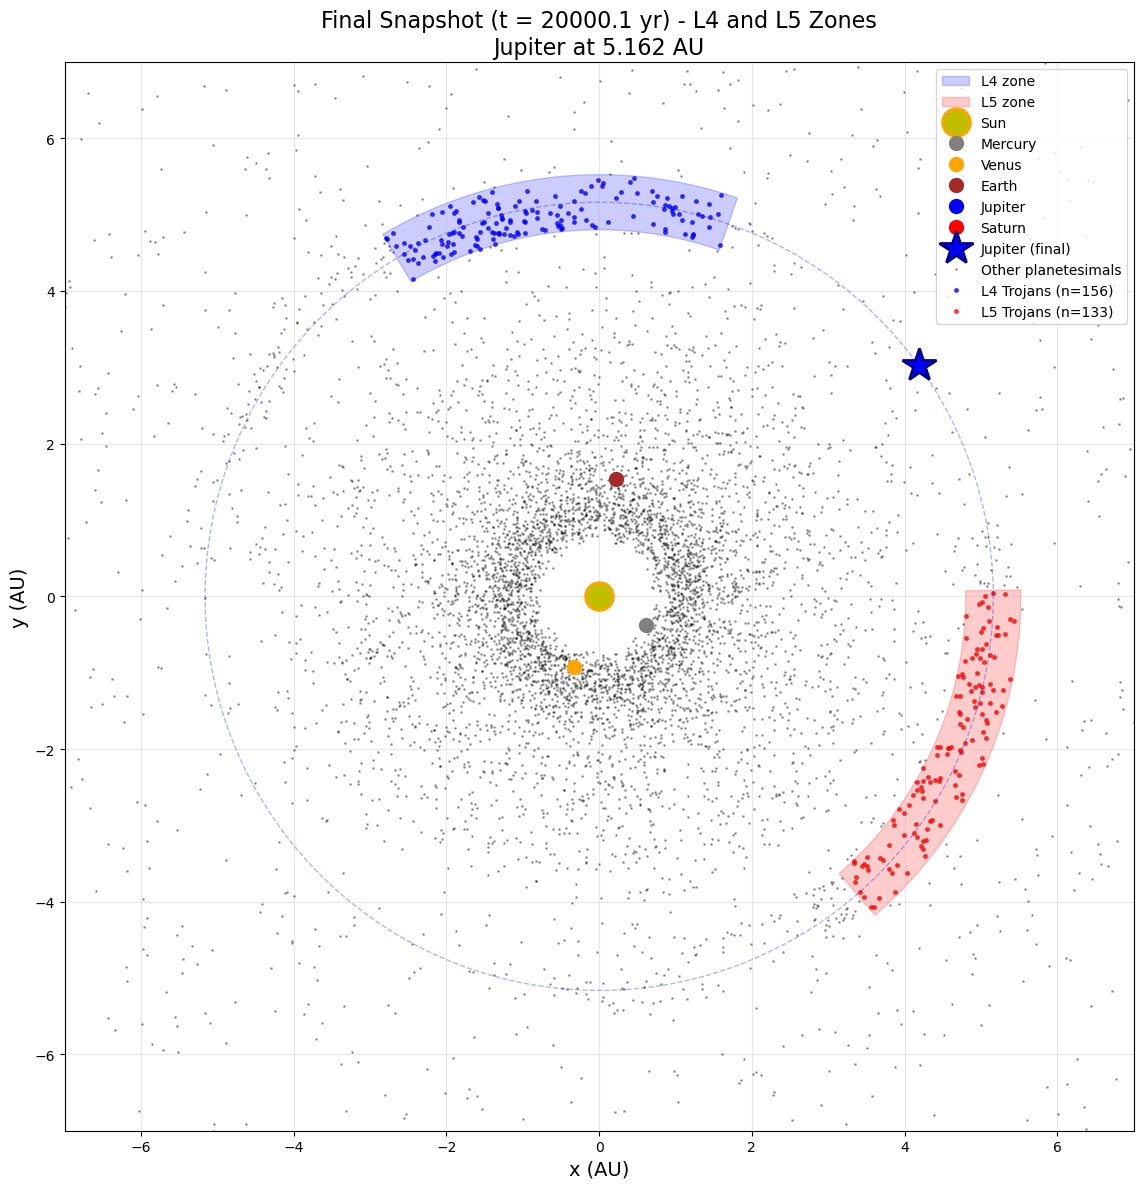


Final L4 count: 156
Final L5 count: 133
Other planetesimals: 9711
Total: 10000


In [ ]:
# Visualize final snapshot with L4 and L5 zones explicitly marked
fig, ax = plt.subplots(figsize=(12, 12))

# Get final snapshot
final_massive = snapshots_massive[-1]
final_planetesimals = snapshots_planetesimals[-1]
jupiter_final = final_massive[4]

# Jupiter's position and semi-major axis
jupiter_x = jupiter_final.x.value_in(units.AU)
jupiter_y = jupiter_final.y.value_in(units.AU)
jupiter_r = np.sqrt(jupiter_x**2 + jupiter_y**2)
jupiter_angle = np.arctan2(jupiter_y, jupiter_x)

# Draw L4 and L5 zones (±25° sectors at ±60° from Jupiter)
L4_angle = jupiter_angle + np.deg2rad(60)
L5_angle = jupiter_angle - np.deg2rad(60)
sector_width = np.deg2rad(25)

# L4 zone (leading Jupiter by 60°)
theta_L4 = np.linspace(L4_angle - sector_width, L4_angle + sector_width, 50)
r_inner_L4 = jupiter_r * 0.93  # 7% co-orbital criterion
r_outer_L4 = jupiter_r * 1.07
x_inner_L4 = r_inner_L4 * np.cos(theta_L4)
y_inner_L4 = r_inner_L4 * np.sin(theta_L4)
x_outer_L4 = r_outer_L4 * np.cos(theta_L4)
y_outer_L4 = r_outer_L4 * np.sin(theta_L4)
ax.fill(np.concatenate([x_inner_L4, x_outer_L4[::-1]]), 
        np.concatenate([y_inner_L4, y_outer_L4[::-1]]), 
        color='blue', alpha=0.2, label='L4 zone')

# L5 zone (trailing Jupiter by 60°)
theta_L5 = np.linspace(L5_angle - sector_width, L5_angle + sector_width, 50)
r_inner_L5 = jupiter_r * 0.93
r_outer_L5 = jupiter_r * 1.07
x_inner_L5 = r_inner_L5 * np.cos(theta_L5)
y_inner_L5 = r_inner_L5 * np.sin(theta_L5)
x_outer_L5 = r_outer_L5 * np.cos(theta_L5)
y_outer_L5 = r_outer_L5 * np.sin(theta_L5)
ax.fill(np.concatenate([x_inner_L5, x_outer_L5[::-1]]), 
        np.concatenate([y_inner_L5, y_outer_L5[::-1]]), 
        color='red', alpha=0.2, label='L5 zone')

# Plot Sun
ax.plot(0, 0, 'yo', markersize=20, markeredgecolor='orange', markeredgewidth=2, label='Sun', zorder=10)

# Plot massive bodies
colors_massive = ['gray', 'orange', 'brown', 'blue', 'red']
names_massive = ['Mercury', 'Venus', 'Earth', 'Jupiter', 'Saturn']
for i, body in enumerate(final_massive[1:6]):  # Skip Sun
    ax.plot(body.x.value_in(units.AU), body.y.value_in(units.AU), 
            'o', color=colors_massive[i], markersize=10, 
            label=names_massive[i], zorder=5)

# Plot Jupiter position markers
ax.plot(jupiter_x, jupiter_y, 'b*', markersize=25, markeredgecolor='darkblue', 
        markeredgewidth=2, label='Jupiter (final)', zorder=6)

# Classify and plot planetesimals
lambda_j = jupiter_angle
a_j = jupiter_r

L4_particles = []
L5_particles = []
other_particles = []

for p in final_planetesimals:
    x = p.x.value_in(units.AU)
    y = p.y.value_in(units.AU)
    r = np.sqrt(x**2 + y**2)
    lam = np.arctan2(y, x)
    dlam = np.arctan2(np.sin(lam - lambda_j), np.cos(lam - lambda_j))
    is_coorb = abs(r/a_j - 1) < 0.07
    
    if (dlam > np.deg2rad(60-25)) and (dlam < np.deg2rad(60+25)) and is_coorb:
        L4_particles.append((x, y))
    elif (dlam < np.deg2rad(-60+25)) and (dlam > np.deg2rad(-60-25)) and is_coorb:
        L5_particles.append((x, y))
    else:
        other_particles.append((x, y))

# Plot planetesimals by category
if other_particles:
    other_x, other_y = zip(*other_particles)
    ax.plot(other_x, other_y, 'k.', markersize=2, alpha=0.3, label='Other planetesimals')

if L4_particles:
    L4_x, L4_y = zip(*L4_particles)
    ax.plot(L4_x, L4_y, 'b.', markersize=5, alpha=0.7, label=f'L4 Trojans (n={len(L4_particles)})')

if L5_particles:
    L5_x, L5_y = zip(*L5_particles)
    ax.plot(L5_x, L5_y, 'r.', markersize=5, alpha=0.7, label=f'L5 Trojans (n={len(L5_particles)})')

# Draw Jupiter orbit
theta_orbit = np.linspace(0, 2*np.pi, 200)
ax.plot(jupiter_r * np.cos(theta_orbit), jupiter_r * np.sin(theta_orbit), 
        'b--', alpha=0.3, linewidth=1)

# Formatting
ax.set_xlabel('x (AU)', fontsize=14)
ax.set_ylabel('y (AU)', fontsize=14)
ax.set_title(f'Final Snapshot (t = {times[-1]:.1f} yr) - L4 and L5 Zones\nJupiter at {jupiter_r:.3f} AU', 
             fontsize=16)
ax.set_aspect('equal')
ax.grid(alpha=0.3)
ax.legend(loc='upper right', fontsize=10)

# Set reasonable plot limits
plot_limit = max(7, jupiter_r * 1.3)
ax.set_xlim(-plot_limit, plot_limit)
ax.set_ylim(-plot_limit, plot_limit)

plt.tight_layout()
plt.show()

print(f'\nFinal L4 count: {len(L4_particles)}')
print(f'Final L5 count: {len(L5_particles)}')
print(f'Other planetesimals: {len(other_particles)}')
print(f'Total: {len(final_planetesimals)}')
